In [ ]:
!pip install lightning > /dev/null
!pip install torchinfo > /dev/null

# Semantic segmentation

A challenging version of general object recognition and scene understanding is to simultaneously perform recognition and accurate boundary segmentation. The basic approach to simultaneous recognition and segmentation is to formulate the problem as one of labeling every pixel in an image with its class membership.

For example, in an image that has many cars, segmentation will label all the objects as car objects. However, a separate class of models known as instance segmentation is able to label the separate instances where an object appears in an image. This kind of segmentation can be very useful in applications that are used to count the number of objects, such as counting the amount of foot traffic in a mall.

![Different kind of segmentation](https://miro.medium.com/v2/resize:fit:720/format:webp/1*SNvD04dEFIDwNAqSXLQC_g.jpeg)

The development of fully convolutional networks enabled per-pixel semantic labeling using a single neural network. Modern semantic segmentation systems are often built on architectures such as the feature pyramid network, which have top-down connections to help filter semantic information down to higher-resolution maps. For example, the Pyramid Scene Parsing Network (PSPNet) uses spatial pyramid pooling to aggregate features at various resolution levels. The Unified Perceptual Parsing network (UPerNet) uses both a feature pyramid network, and a pyramid pooling module to label image pixels not only with object categories but also materials, parts, and textures.

A notable example is SegNet, a model designed for pixel-wise, multi-class segmentation on urban road scene datasets. This model was created by researchers from the University of Cambridge’s Computer Vision Group.

![Segnet](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2023/07/segnet-AE.jpg?size=630x192&lossy=2&strip=1&webp=1)

**Having said that, most models are based on autoencoders.**

## Autoencoders

An autoencoder is an artificial neural network used for unsupervised learning tasks (i.e., no class labels or labeled data) such as dimensionality reduction, feature extraction, and data compression. They seek to:

- Accept an input set of data (i.e., the input)
- Internally compress the input data into a latent space representation (i.e., a single vector that compresses and quantifies the input)
- Reconstruct the input data from this latent representation (i.e., the output).

Latent space allows an AI system to position data points based on their similarities and differences. Similar data points are closer together, while dissimilar ones are farther apart. This arrangement helps the model learn the relationships between different pieces of data.


![Latent space](https://pyimagesearch.com/wp-content/uploads/2023/07/vanilla-AE.png)

An autoencoder consists of the following two primary components:

- **Encoder**: The encoder compresses input data into a lower-dimensional representation known as the latent space or code. This latent space, often called embedding, aims to retain as much information as possible, allowing the decoder to reconstruct the data with high precision. If we denote our input data as $x$ and the encoder as $E$, then the output latent space representation, $s$, would be $s=E(x)$.
- **Decoder**: The decoder reconstructs the original input data by accepting the latent space representation $s$. If we denote the decoder function as $D$ and the output of the detector as $o$, then we can represent the decoder as $o = D(s)$.

![Autoencoders](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2023/07/autoencoder_arch.png?lossy=2&strip=1&webp=1)

Both encoder and decoder are typically composed of one or more layers, which can be fully connected, convolutional, or recurrent, depending on the input data’s nature and the autoencoder’s architecture.

### Vanilla Autoencoders

These usually consist of one or more fully connected layers for both the encoder and decoder. It works well for simple data but may struggle with complex patterns.

![Vanilla](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2023/07/vanilla-AE.png?size=630x472&lossy=2&strip=1&webp=1)

### Convolutional Autoencoder (CAE)

These use convolutional layers in both the encoder and decoder, making it suitable for handling image data. By exploiting the spatial information in images, CAEs can capture complex patterns and structures more effectively than vanilla autoencoders and accomplish tasks such as image segmentation.

![Convnets for segmentation](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2023/07/conv-AE.png?size=630x302&lossy=2&strip=1&webp=1)

An autoencoder aims to reduce the discrepancy, or loss, between the original data and the reconstructed data at the decoder end, aiming to recreate the input as accurately as possible. This loss function is often referred to as the reconstruction error. The most common loss functions used for autoencoders are mean squared error (MSE) or binary cross-entropy (BCE), depending on the input data’s nature.

## Segmentation using *Segmentation Models*

We will use a Python library with Neural Networks for Image Segmentation called [Segmentation Models](https://github.com/qubvel/segmentation_models.pytorch?tab=readme-ov-file#start), to get model architectures, metrics, and losses.

The main features of this library are:

- High level API (just two lines to create a neural network)
- 9 models architectures for binary and multi class segmentation (including legendary Unet)
- 124 available encoders (and 500+ encoders from timm)
- All encoders have pre-trained weights for faster and better convergence
- Popular metrics and losses for training routines

The documentation is available [here](https://smp.readthedocs.io/).

To install the library, we use the following command:

```bash
!pip install -U segmentation-models-pytorch > /dev/null
```

In [ ]:
!pip install -U segmentation-models-pytorch > /dev/null

## Basic imports

In [ ]:
import os, glob, random, shutil, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchinfo import summary

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

## Loading the dataset

This example shows how to use segmentation-models-pytorch for **binary semantic segmentation**. We will use the The [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which contains a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose, and lighting. All images have an associated ground truth annotation of breed, head region of interest (ROI), and pixel level segmentation.

![Oxford pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

For now, we will use the dataset utilities provided by the Segmentation models library.

In [ ]:
root = "./data/"
SimpleOxfordPetDataset.download(root)

images.tar.gz: 100%|██████████| 755M/755M [00:07<00:00, 99.7MB/s]
annotations.tar.gz: 100%|██████████| 18.3M/18.3M [00:00<00:00, 60.7MB/s]


In [ ]:
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, persistent_workers=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, persistent_workers=True)

Train size: 3312
Valid size: 368
Test size: 3669


###  Visualizing the dataset

The dataset already has 3 elements that are noteworthy: and image array, a mask array, and a trimap array. We will use the image and mask arrays.

In [ ]:
train_batch = next(iter(train_dataloader))

print(train_batch['image'].shape)
print(train_batch['mask'].shape)
print(train_batch['trimap'].shape)
print(train_batch.keys())

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
dict_keys(['image', 'mask', 'trimap'])


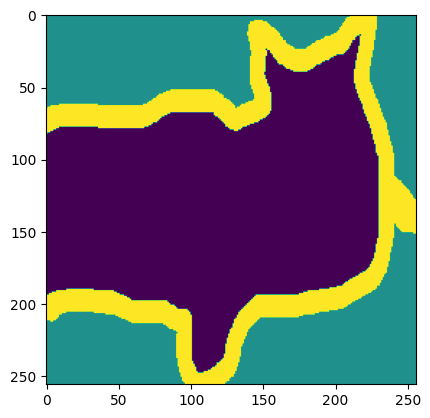

In [ ]:
plt.imshow(np.transpose(train_batch['trimap'][0], (1, 2, 0)))

The mask is an array of black and white pixels that represent objects in the image.

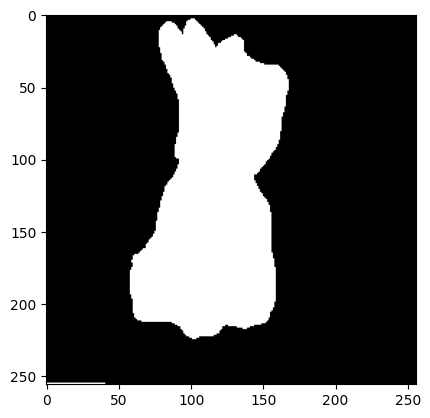

In [ ]:
plt.imshow(np.transpose(train_batch['mask'][0], (1, 2, 0)), cmap='gray')

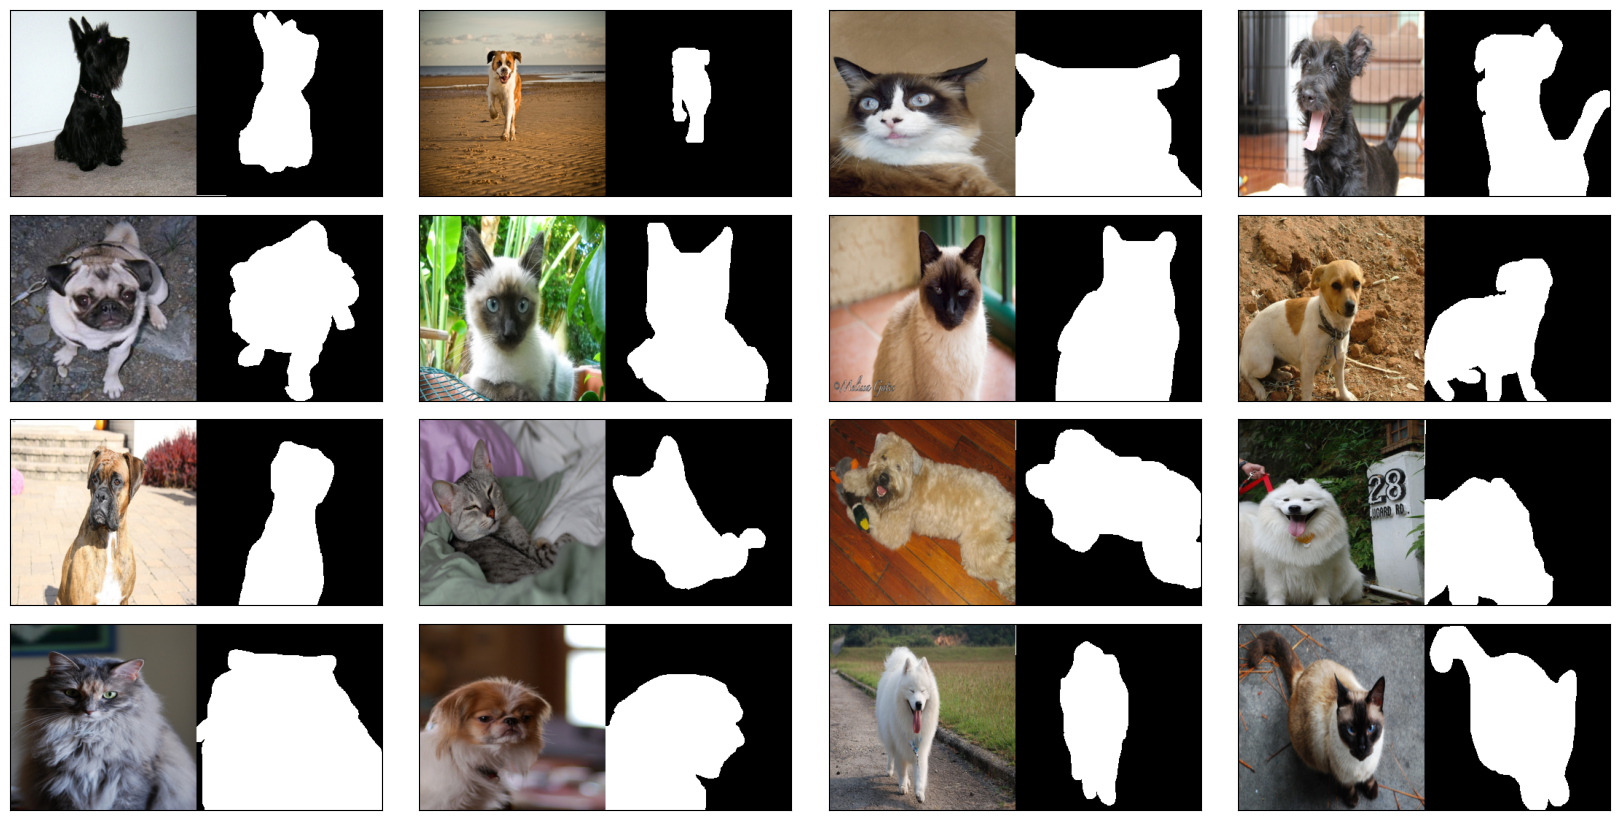

In [ ]:
# Create a 5x5 subplot figure
f, ax = plt.subplots(4, 4, figsize=(20, 10))
# Adjust the layout of the subplots to avoid overlapping
f.tight_layout(pad=0.)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)

# Iterate over the first 25 test images
for idx in range(16):
    # Calculate the row and column index for the subplot
    row = idx // 4
    col = idx % 4

    image = train_batch['image'][idx].numpy()
    image = image.transpose((1, 2, 0))

    mask = train_batch['mask'][idx].numpy()
    mask = mask.transpose((1, 2, 0)).squeeze()
    mask = (mask * 255.0).astype("uint8")

    image_mask = np.zeros((256, 512, 3), dtype=np.uint8)

    image_mask[:, :256, :] = image
    image_mask[:, 256:, 0] = mask
    image_mask[:, 256:, 1] = mask
    image_mask[:, 256:, 2] = mask


    ax[row, col].imshow(image_mask)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

## Model

We will use a class that takes a model architecture of the model, the name of the encoder, the number of input channels in the images, and the number of output classes. You can change these parameters to suit a given problem. We are introducing two concepts that are used to evaluate semantic segmentation models:

- Dice Loss: Dice loss, also known as the Sørensen-Dice coefficient, is a popular choice for image segmentation. It measures the overlap between the predicted and target segmentation masks.
- Intersection over Union (IoU): A popular metric to measure localization accuracy and compute localization errors in object detection models. It calculates the amount of overlapping between two bounding boxes, or pixel areas.

![IoU](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/647a0e1b55ad60f00d6e0604_IoU%20comparative%20performance.webp)

In [ ]:
class PetModel(L.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes):
        '''
            Initializes an instance of the SemanticSegmentation class.

            Parameters:
            - arch (str): The architecture of the model.
            - encoder_name (str): The name of the encoder.
            - in_channels (int): The number of input channels.
            - out_classes (int): The number of output classes.
        '''
        super().__init__()

        '''
            It is important to note that we are not using a trained encoder. To use a trained encoder, change
            The value in the encoder_weight parameter.
        '''
        self.model = smp.create_model(arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, encoder_weights=None)

        '''
           These are used to store the computed true positive, false positive, false negative and true negative 'pixels' for each image and class
        '''
        self.tp = None
        self.fp = None
        self.fn = None
        self.tn = None

        '''
            These are used to store the computed losses for each stage
        '''
        self.losses = {
            'valid': [],
            'train': [],
            'test': []
        }

        '''
            These parameters are used to normalize the input image. Models from the segmentation_models_pytorch library
            require the input image to be normalized. The mean and standard deviation values are used to normalize the image.
            The mean and standard deviation values are obtained from the get_preprocessing_params function of the encoders module.
        '''
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        '''
            Dice Loss: Dice loss, also known as the Sørensen-Dice coefficient, is a popular choice for image segmentation.
            It measures the overlap between the predicted and target segmentation masks.
        '''
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):

        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"]

        '''
            Shape of the image should be (batch_size, num_channels, height, width)
            if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        '''
        assert image.ndim == 4

        '''
            Check that image dimensions are divisible by 32,
            encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
            downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
            following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
            and we will get an error trying to concat these features
        '''
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width] for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold: first convert mask values to probabilities, then apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        '''
            We will compute IoU metric by two ways
              1. dataset-wise
              2. image-wise
            but for now we just compute true positive, false positive, false negative and
            true negative 'pixels' for each image and class
            these values will be aggregated in the end of an epoch
        '''
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        self.tp = tp
        self.fp = fp
        self.tn = tn
        self.fn = fn

        self.losses[stage].append(loss)

        return loss

    def shared_epoch_end(self, stage):
        # aggregate step metics
        tp = self.tp
        fp = self.fp
        fn = self.fn
        tn = self.tn

        '''
            Per image IoU means that we first calculate IoU score for each image
            and then compute mean over these scores
        '''
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        '''
            Dataset IoU means that we aggregate intersection and union over whole dataset
            and then compute IoU score. The difference between dataset_iou and per_image_iou scores
            in this particular case will not be much, however for dataset
            with "empty" images (images without target class) a large gap could be observed.
            Empty images influence a lot on per_image_iou and much less on dataset_iou.
        '''
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_loss": torch.stack(self.losses[stage]).mean(),
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True, logger=True)

    '''
        These are pytorch lightning hooks that are called during the training, validation and testing steps.
        Hooks are used to perform additional operations during these steps. In this case, we are using the hooks
        to compute the loss and metrics for each step and epoch.
    '''
    def training_step(self, batch):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)

## Training

In [ ]:
# Early stop is a callback that is used to stop the training process when the validation loss does not improve. In this case, we are
# using the EarlyStopping callback to stop the training process when the validation loss does not improve for 3 epochs.
earlystop_callback = EarlyStopping('valid_loss', patience=3)

trainer = L.Trainer(max_epochs=15, logger=CSVLogger(save_dir="logs/", name="pets_seg-model"), callbacks=[earlystop_callback])

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 23.2 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)
175       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type     | Param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [ ]:
# We verify the training using the validate method of the trainer object. The validate method returns the metrics for the validation dataset.
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_loss': 0.1471162736415863, 'valid_per_image_iou': 0.8272872567176819, 'valid_dataset_iou': 0.8246635794639587}]


In [ ]:
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_loss': 0.12270747870206833, 'test_per_image_iou': 0.760955274105072, 'test_dataset_iou': 0.7934448719024658}]


### Visualizing training results

,step,test_dataset_iou,test_loss,test_per_image_iou,train_dataset_iou,train_loss,train_per_image_iou,valid_dataset_iou,valid_loss,valid_per_image_iou
epoch,,,,,,,,,,
0,206.0,NaN,NaN,NaN,0.663339,0.259100,0.663708,0.663339,0.237368,0.663708
1,413.0,NaN,NaN,NaN,0.755785,0.224387,0.747290,0.755785,0.208762,0.747290
2,620.0,NaN,NaN,NaN,0.789257,0.203572,0.783751,0.789257,0.189740,0.783751
3,827.0,NaN,NaN,NaN,0.805366,0.188842,0.794318,0.805366,0.179392,0.794318
4,1034.0,NaN,NaN,NaN,0.827424,0.177215,0.818916,0.827424,0.170877,0.818916
5,1241.0,NaN,NaN,NaN,0.796486,0.167776,0.789123,0.796486,0.165862,0.789123
6,1448.0,NaN,NaN,NaN,0.797506,0.159692,0.791148,0.797506,0.162390,0.791148
7,1655.0,NaN,NaN,NaN,0.823236,0.152476,0.825530,0.823236,0.158442,0.825530
8,1862.0,NaN,NaN,NaN,0.787967,0.145989,0.805959,0.787967,0.157565,0.805959


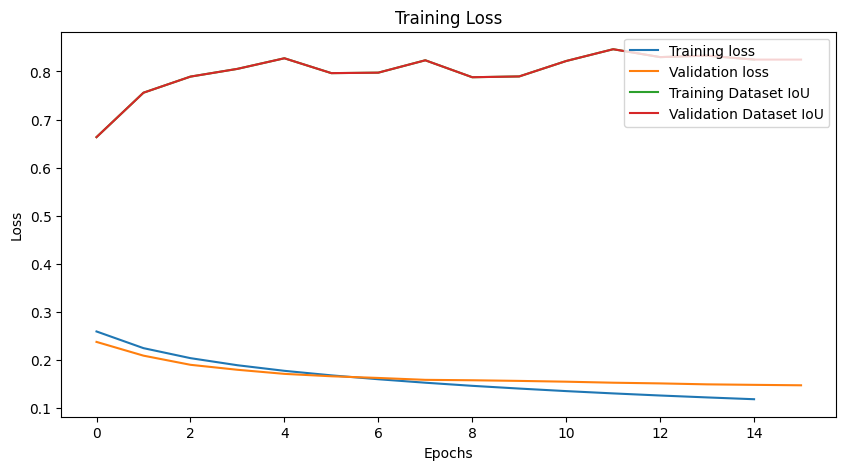

In [ ]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

display(df_epochs)

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
ax.plot(df_epochs['train_loss'], label="Training loss")
ax.plot(df_epochs['valid_loss'], label="Validation loss")

ax.plot(df_epochs['train_dataset_iou'], label="Training Dataset IoU")
ax.plot(df_epochs['valid_dataset_iou'], label="Validation Dataset IoU")

# Plot the training loss over epochs
# Plot the validation loss over epochs
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

Output hidden; open in https://colab.research.google.com to view.